<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Mask_RCNN/blob/master/train_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

#!git clone https://github.com/matterport/Mask_RCNN
!git clone https://github.com/larrygoyeau/bubble_segmentation_Mask_RCNN
!pip install -r /content/drive/My\ Drive/Mask_RCNN/requirements.txt
!pip install git+https://github.com/aleju/imgaug.git

TensorFlow 1.x selected.
Cloning into 'bubble_segmentation_Mask_RCNN'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 232 (delta 95), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (232/232), 2.40 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (101/101), done.
     |████████████████████████████████| 163kB 4.8MB/s 
     |████████████████████████████████| 204kB 10.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5ba781ce46b6168fedd5b9df0a285eaf2947dd78c62a46a650fb7a18543ef26e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-g80i2zq7
  Running command git clone -q https://g

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Mask_RCNN')

import resource
import os
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive")

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


## Configurations

In [0]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    RPN_NMS_THRESHOLD=0.8
    DETECTION_MIN_CONFIDENCE = 0
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side

    # Random crops of size 256x256
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the images have a lot of bubbles
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        350
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

## Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [0]:
# To increas the recursion limite
resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

DATA_DIR = '/content/bubble_segmentation_Mask_RCNN/data_set'

x_train_dir = os.path.join(DATA_DIR, 'image_train')
interior_y_train_dir = os.path.join(DATA_DIR, 'interior_mask_train')
contour_y_train_dir = os.path.join(DATA_DIR, 'contour_mask_train')

x_valid_dir = os.path.join(DATA_DIR, 'image_validation')
interior_y_valid_dir = os.path.join(DATA_DIR, 'interior_mask_validation')
contour_y_valid_dir = os.path.join(DATA_DIR, 'contour_mask_validation')

x_test_dir = os.path.join(DATA_DIR, 'image_test')

def color_bubble(mask_of_one_bubble,mask,i,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done):
  if mask[i,j]<color_of_bubbles_to_be_done:
    mask[i,j]=color_of_bubble_done
    mask_of_one_bubble[i,j]=1
    if 0<j:
      color_bubble(mask_of_one_bubble,mask,i,j-1,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if i<I-1:
      color_bubble(mask_of_one_bubble,mask,i+1,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if 0<i:
      color_bubble(mask_of_one_bubble,mask,i-1,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if j<J-1:
      color_bubble(mask_of_one_bubble,mask,i,j+1,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)

class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self,images_dir, masks_dir):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "bubble")

        # Add images
        self.ids_image = os.listdir(images_dir)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_image]
        if masks_dir!=None:
          self.masks_fps = [os.path.join(masks_dir,'mask'+image_id[5:]) for image_id in self.ids_image]
        else:
          self.masks_fps=None

        count=len(self.ids_image)
        
        for i in range(count):
            self.add_image("shapes", image_id=i, path=self.images_fps[i],path_mask=self.masks_fps[i])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = cv2.imread(info['path'])
        if len(image)>2**11:
          image=image[:2**11,:]
        if len(image[0])>2**11:
          image=image[:,:2**11]
        shape_image=image.shape
        p=255/(image.max()-image.min())
        image=(image-image.min())*p
        image= image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        mask = cv2.imread(info['path_mask'], 0)
        I=len(mask)
        J=len(mask[0])
        number_of_bubbles=0
        list_of_mask=[]
        for i in range(I):
          for j in range(J):
            if mask[i,j]<5:
              mask_of_one_bubble=np.zeros( mask.shape, dtype=np.int32 )
              color_bubble(mask_of_one_bubble,mask,i,j,I,J,255,5)
              list_of_mask=list_of_mask+[mask_of_one_bubble]
              number_of_bubbles=number_of_bubbles+1
        list_of_mask=np.random.permutation(list_of_mask)
        mask_of_all_bubbles = np.stack(list_of_mask, axis=-1).astype('int')
        class_ids = np.ones((number_of_bubbles))
        return mask_of_all_bubbles.astype(np.bool), class_ids.astype(np.int32)


In [0]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(x_train_dir, interior_y_train_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(x_valid_dir, interior_y_valid_dir)
dataset_val.prepare()

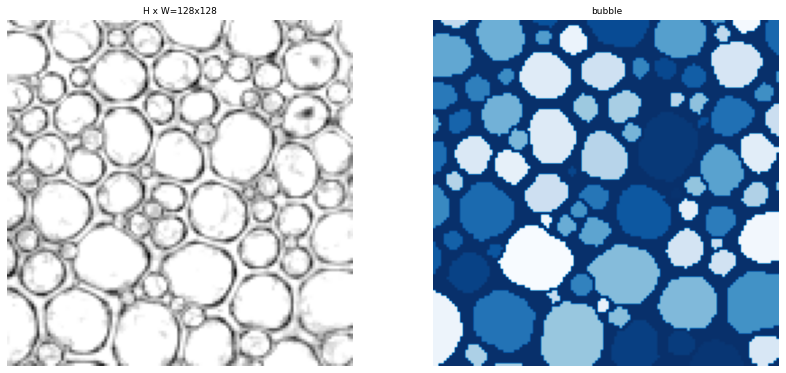

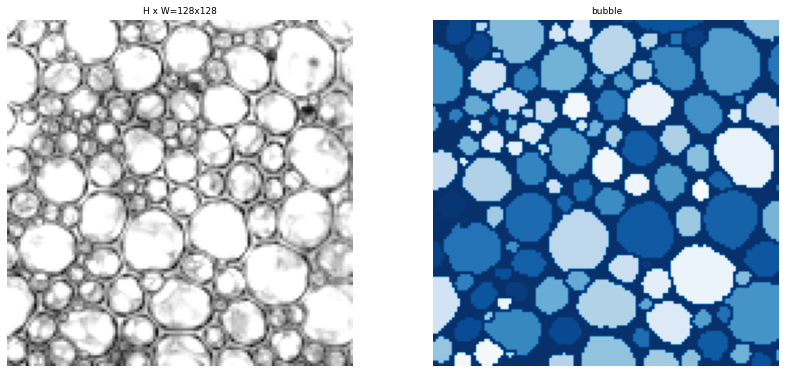

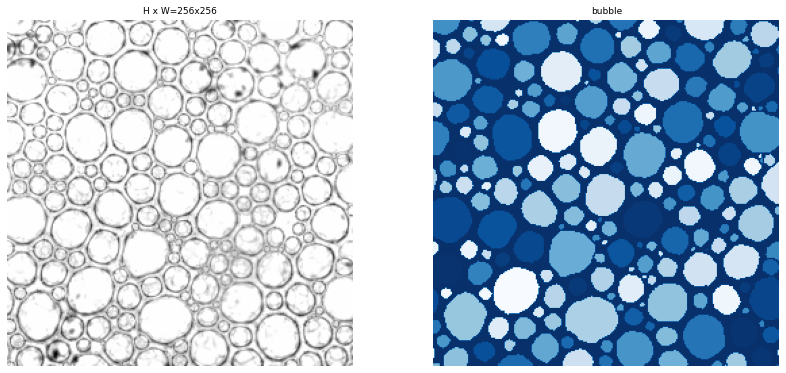

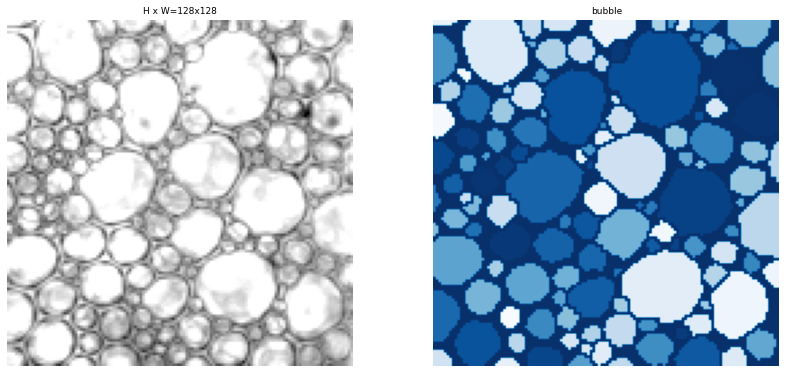

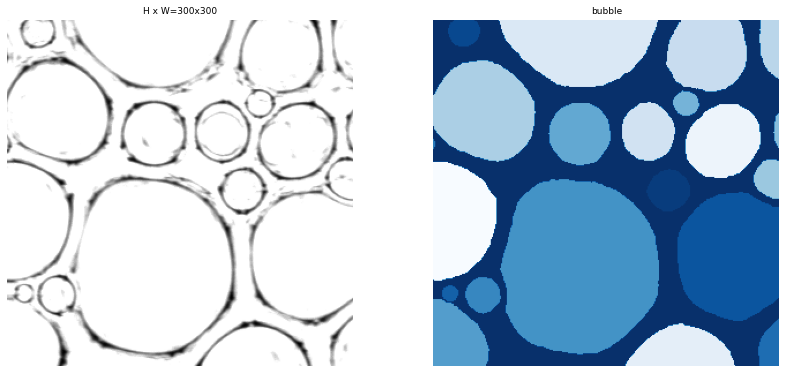

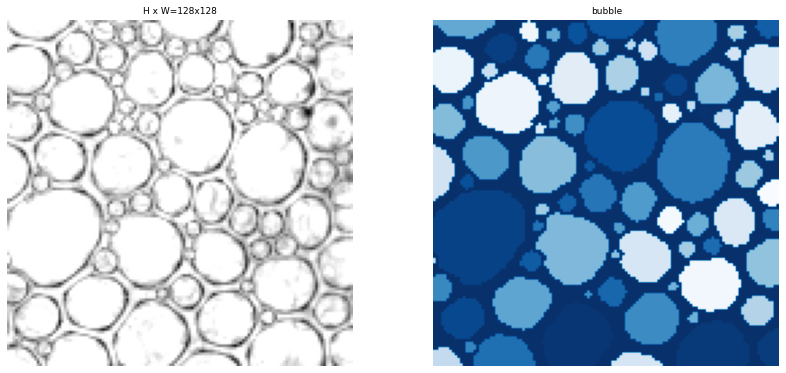

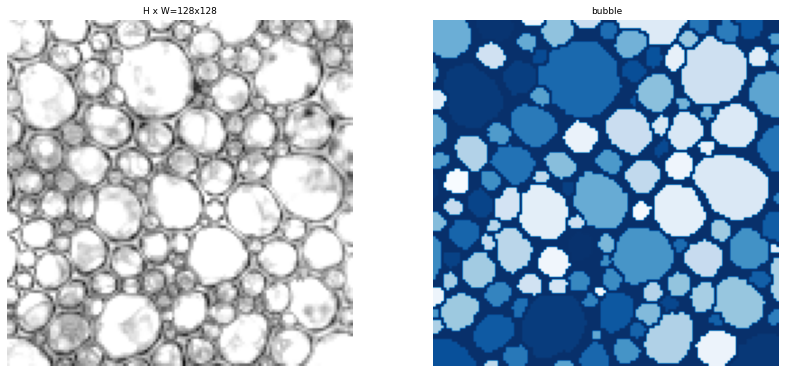

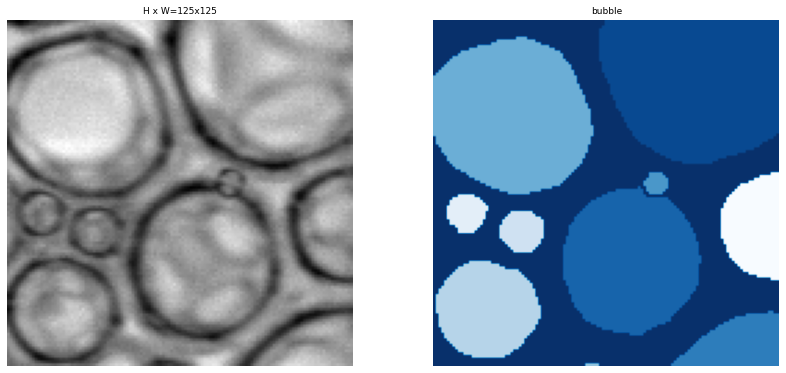

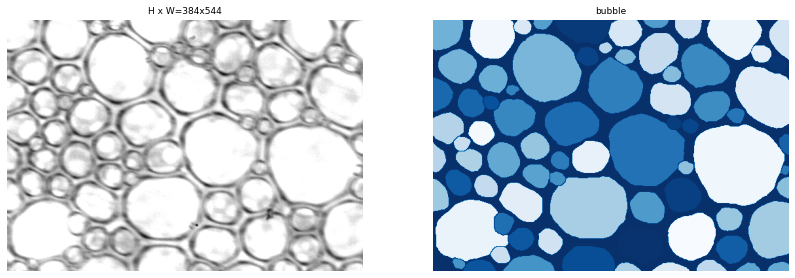

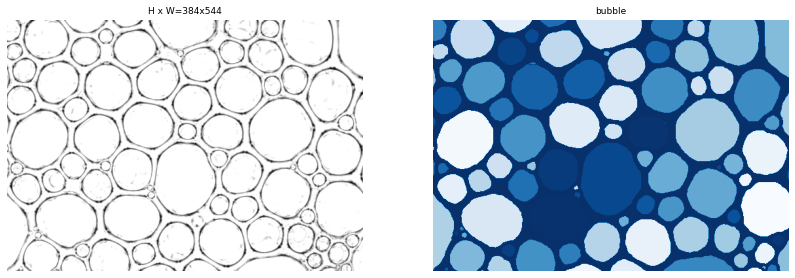

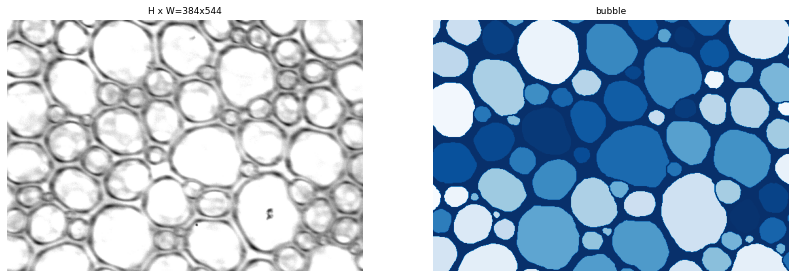

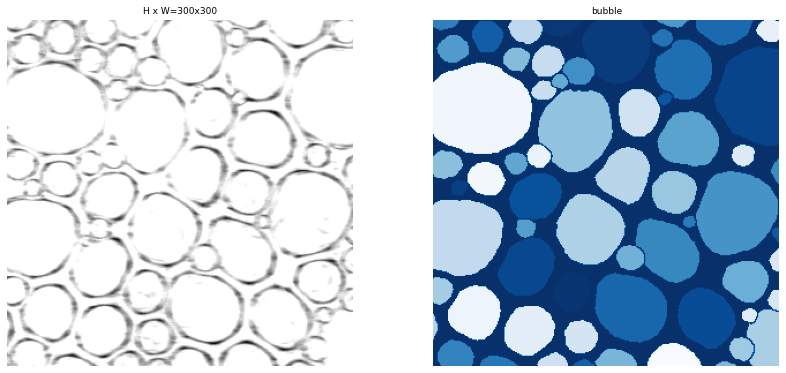

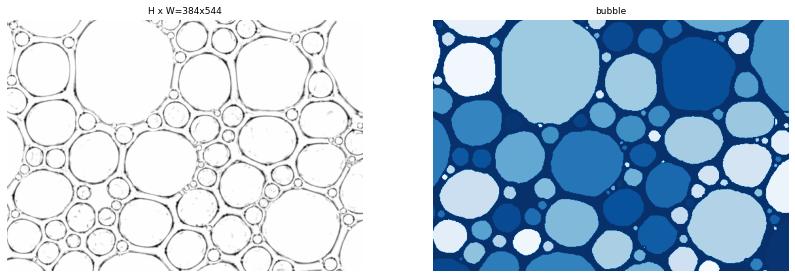

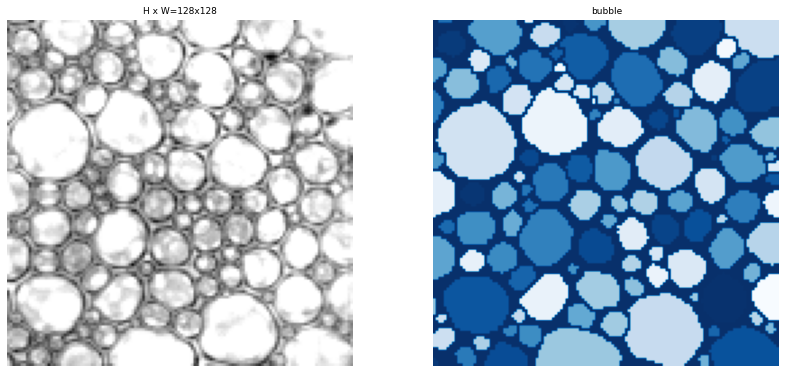

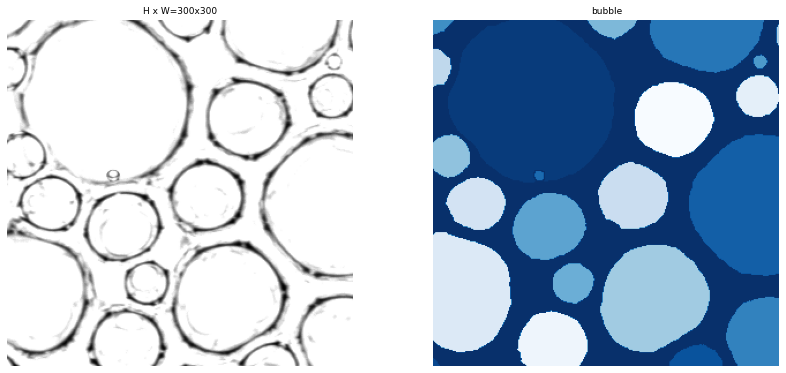

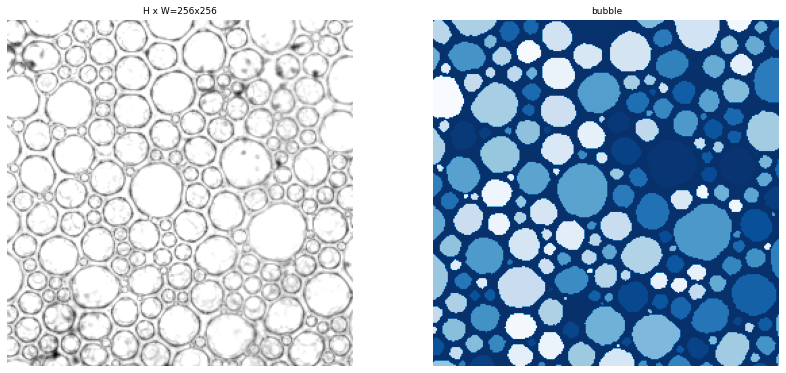

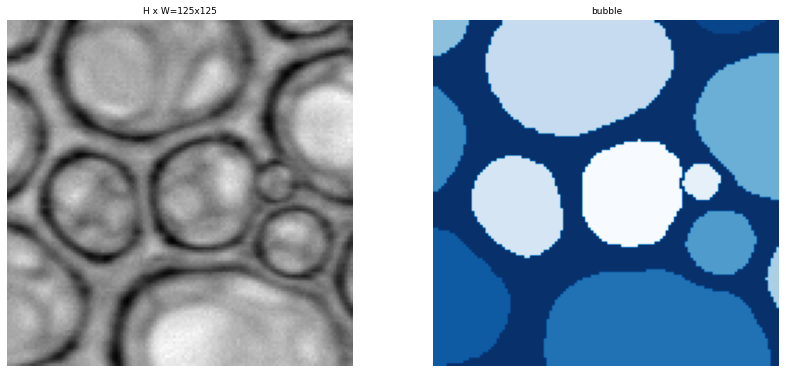

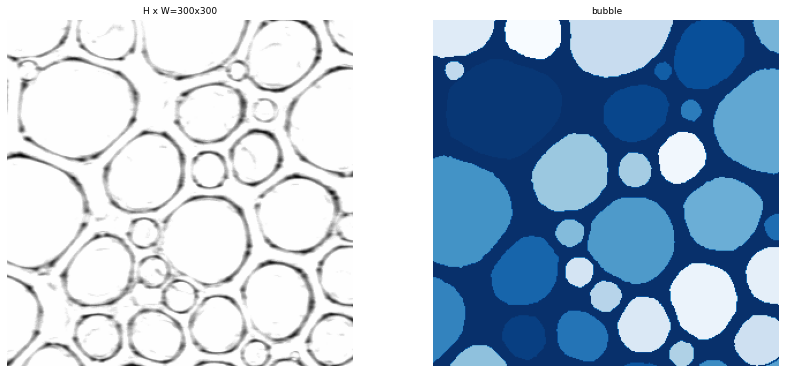

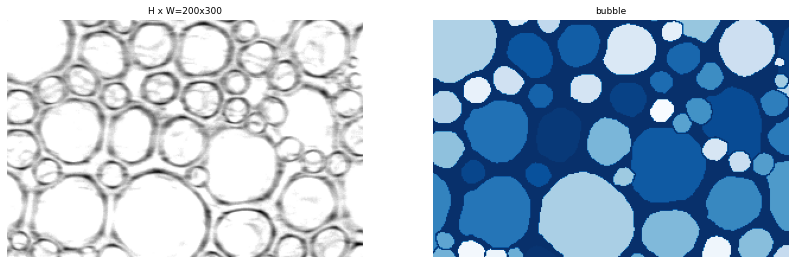

In [0]:
# Load and display samples

n =len(os.listdir(x_train_dir))
for image_id in range(n):
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)


# Data augmentation

In [0]:
augment = iaa.SomeOf((1,3), [
        iaa.Fliplr(1),
        iaa.Flipud(1),
        iaa.Affine(rotate=(-90, 90)),
        iaa.Multiply((0.8, 1),per_channel=0.5),
        #iaa.WithChannels(0, iaa.Add((10, 60))),
        #iaa.Add((-25, 25), per_channel=0.5),
        #iaa.AddToHueAndSaturation((-50, 50), per_channel=True),
        #iaa.ChangeColorTemperature((4000, 5000)),
        #iaa.GammaContrast((0.5, 2.0), per_channel=True),
        #iaa.AllChannelsHistogramEqualization(),
        #iaa.PiecewiseAffine(scale=(0.04, 0.06)),
        iaa.PiecewiseAffine(scale=(0.04, 0.06))

    ])

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


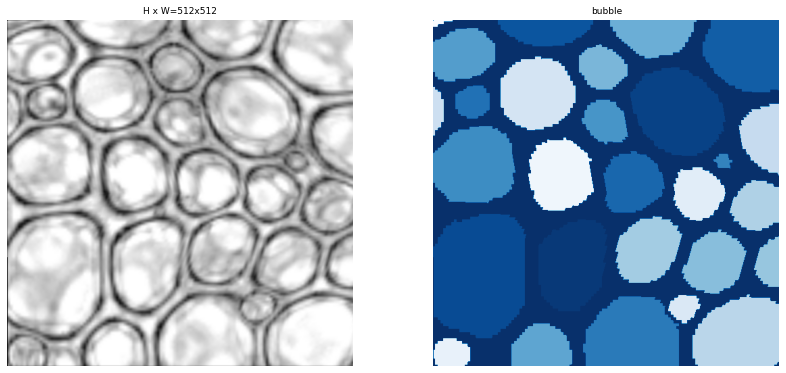

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


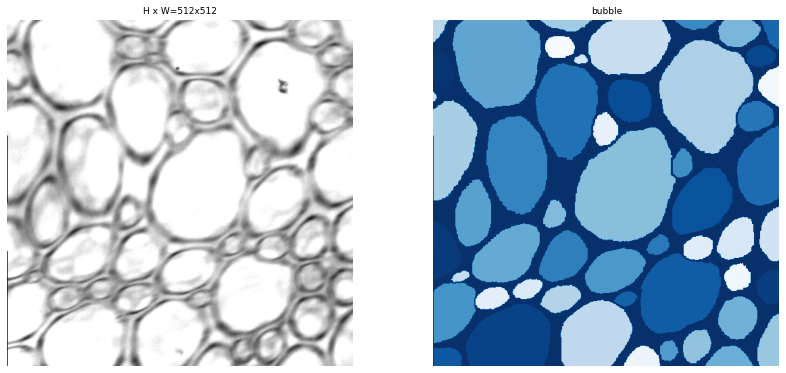

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 110) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


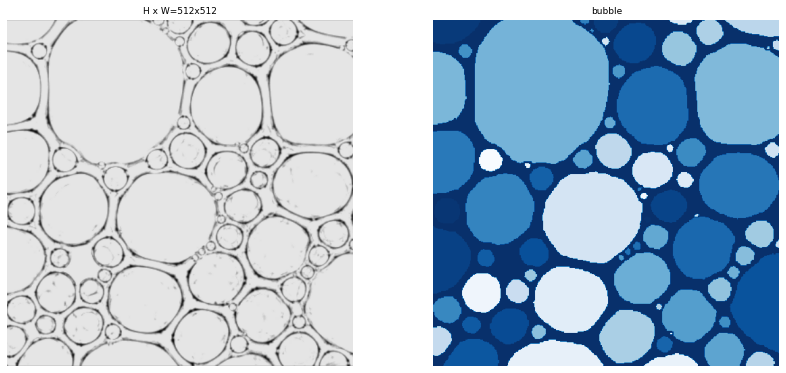

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 206) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


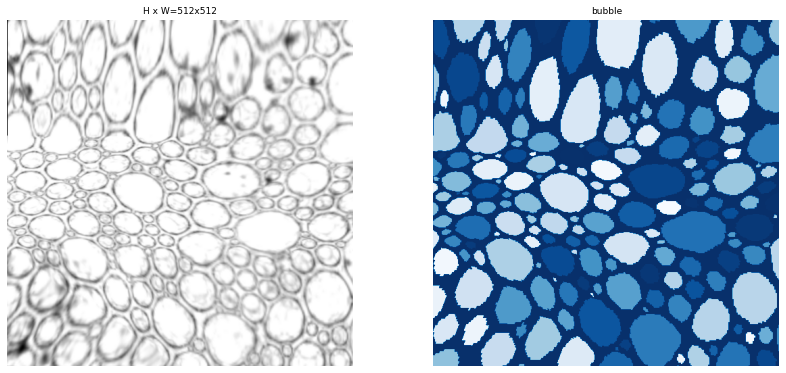

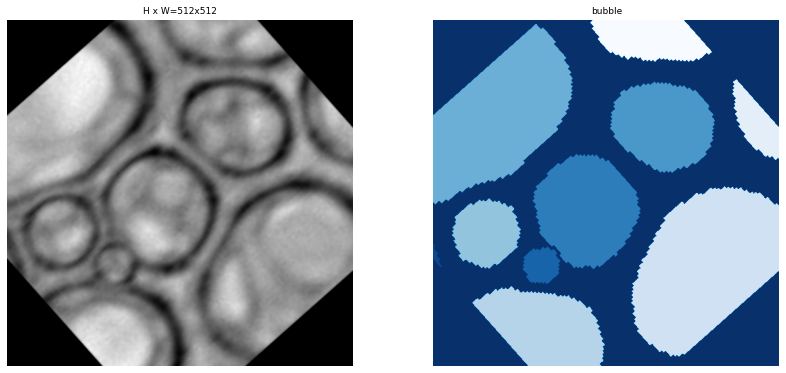

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


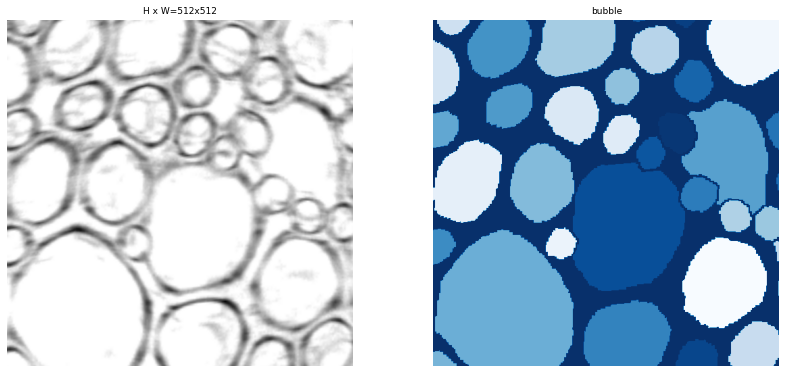

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 115) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


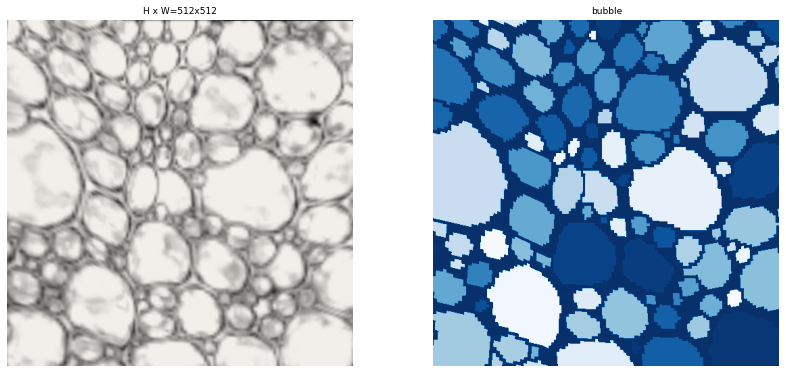

In [0]:
# Load and display samples

n =len(os.listdir(x_valid_dir))
for image_id in range(n):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset_val, config, image_id, augmentation=augment)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names,limit=1)
    

## Create Model

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

    # Load the last model you trained and continue training
model.load_weights(model.find_last(), by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Re-starting from epoch 38


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [0]:
epochs_number=39
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=epochs_number, 
            layers='heads',
            augmentation=augment
            )


Starting at epoch 38. LR=0.0001

Checkpoint Path: /content/drive/My Drive/logs/shapes20200413T1553/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleIma

Epoch 39/39


/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 29/100 [=======>......................] - ETA: 1:48 - loss: 1.0306

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 78) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 32/100 [========>.....................] - ETA: 1:35 - loss: 1.0219

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 78) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 78) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 36/100 [=========>....................] - ETA: 1:31 - loss: 1.0304

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 93) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 93) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 38/100 [==========>...................] - ETA: 1:31 - loss: 1.0299

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 93) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 93) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 40/100 [===========>..................] - ETA: 1:26 - loss: 1.0240

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 206) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 206) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

 43/100 [===========>..................] - ETA: 1:22 - loss: 1.0136

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 44/100 [============>.................] - ETA: 1:20 - loss: 1.0090

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

 46/100 [============>.................] - ETA: 2:25 - loss: 1.0159

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 47/100 [=============>................] - ETA: 2:53 - loss: 1.0202

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 78) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 78) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 76/100 [=====================>........] - ETA: 59s - loss: 0.9828 

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 78/100 [======================>.......] - ETA: 53s - loss: 0.9877

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 80/100 [=======================>......] - ETA: 47s - loss: 0.9972

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 88/100 [=========================>....] - ETA: 26s - loss: 0.9994

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

 89/100 [=========================>....] - ETA: 31s - loss: 1.0020

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use 

 97/100 [============================>.] - ETA: 9s - loss: 1.0026 

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use 

 99/100 [============================>.] - ETA: 3s - loss: 1.0013

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use 

100/100 [==============================] - 321s 3s/step - loss: 1.0011 - val_loss: 0.4909



/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=epochs_number+2, 
            layers="all",
            augmentation=augment
            )


Starting at epoch 39. LR=1e-05

Checkpoint Path: /content/drive/My Drive/logs/shapes20200413T1553/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 40/41


/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

  5/100 [>.............................] - ETA: 22:30 - loss: 1.1106

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

  8/100 [=>............................] - ETA: 13:51 - loss: 1.0488

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 10/100 [==>...........................] - ETA: 10:57 - loss: 1.0188

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 125) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 44/100 [============>.................] - ETA: 1:47 - loss: 0.9249

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 47/100 [=============>................] - ETA: 3:18 - loss: 0.9350

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 49/100 [=============>................] - ETA: 3:34 - loss: 0.9398

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 51/100 [==============>...............] - ETA: 3:18 - loss: 0.9397

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 52/100 [==============>...............] - ETA: 3:11 - loss: 0.9367

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 53/100 [==============>...............] - ETA: 3:04 - loss: 0.9367

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 61/100 [=================>............] - ETA: 2:15 - loss: 0.9241

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 62/100 [=================>............] - ETA: 2:09 - loss: 0.9195

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 65/100 [==================>...........] - ETA: 1:54 - loss: 0.9114

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 66/100 [==================>...........] - ETA: 1:49 - loss: 0.9110

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 83/100 [=======================>......] - ETA: 44s - loss: 0.9234

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 84/100 [========================>.....] - ETA: 41s - loss: 0.9228

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 87/100 [=========================>....] - ETA: 33s - loss: 0.9220

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 88/100 [=========================>....] - ETA: 30s - loss: 0.9214

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 92/100 [==========================>...] - ETA: 29s - loss: 0.9320

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 93/100 [==========================>...] - ETA: 25s - loss: 0.9318

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 95/100 [===========================>..] - ETA: 18s - loss: 0.9307

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 96/100 [===========================>..] - ETA: 14s - loss: 0.9300

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 98/100 [============================>.] - ETA: 7s - loss: 0.9289 

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 99/100 [============================>.] - ETA: 3s - loss: 0.9284

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use

100/100 [==============================] - 354s 4s/step - loss: 0.9288 - val_loss: 0.4314
Epoch 41/41
 14/100 [===>..........................] - ETA: 30s - loss: 0.7354

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 20/100 [=====>........................] - ETA: 28s - loss: 0.7554

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 22/100 [=====>........................] - ETA: 28s - loss: 0.7998

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 26/100 [======>.......................] - ETA: 27s - loss: 0.8146

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 30/100 [========>.....................] - ETA: 26s - loss: 0.8301

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 32/100 [========>.....................] - ETA: 25s - loss: 0.8312

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 35/100 [=========>....................] - ETA: 4:06 - loss: 0.8567

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 39/100 [==========>...................] - ETA: 3:30 - loss: 0.8613

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use 

 41/100 [===========>..................] - ETA: 3:14 - loss: 0.8621

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 46/100 [============>.................] - ETA: 2:41 - loss: 0.8623

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 47/100 [=============>................] - ETA: 2:35 - loss: 0.8612

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 50/100 [==============>...............] - ETA: 2:18 - loss: 0.8497

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 52/100 [==============>...............] - ETA: 2:08 - loss: 0.8502

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 54/100 [===============>..............] - ETA: 1:59 - loss: 0.8410

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 57/100 [================>.............] - ETA: 1:46 - loss: 0.8365

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 72/100 [====================>.........] - ETA: 57s - loss: 0.8622 

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 74/100 [=====================>........] - ETA: 52s - loss: 0.8627

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 75/100 [=====================>........] - ETA: 49s - loss: 0.8601

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 76/100 [=====================>........] - ETA: 47s - loss: 0.8621

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 79/100 [======================>.......] - ETA: 1:11 - loss: 0.8710

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 82/100 [=======================>......] - ETA: 59s - loss: 0.8795 

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 84/100 [========================>.....] - ETA: 51s - loss: 0.8794

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use 

 85/100 [========================>.....] - ETA: 48s - loss: 0.8807

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 87/100 [=========================>....] - ETA: 40s - loss: 0.8810

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 90/100 [==========================>...] - ETA: 30s - loss: 0.8778

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 119) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 96/100 [===========================>..] - ETA: 11s - loss: 0.8690

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

 99/100 [============================>.] - ETA: 2s - loss: 0.8657

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)
/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 82) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e

100/100 [==============================] - 279s 3s/step - loss: 0.8671 - val_loss: 1.0452


## Evaluation

In [0]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_NMS_THRESHOLD = 0.7
    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    DETECTION_MIN_CONFIDENCE=0


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

inference_config.display()

Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
177
Processing 1 images
image                    shape: (128, 128, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
27
Processing 1 images
image                    shape: (128, 128, 3)         min:  117.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -6.70000  max:

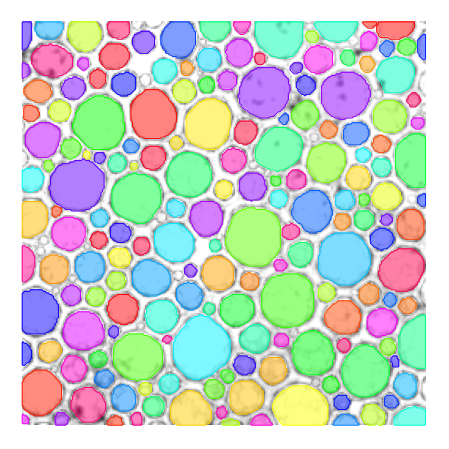

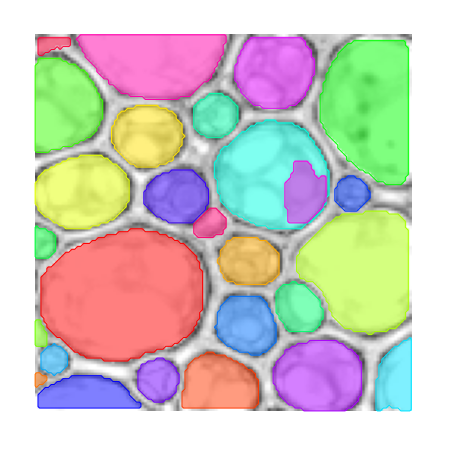

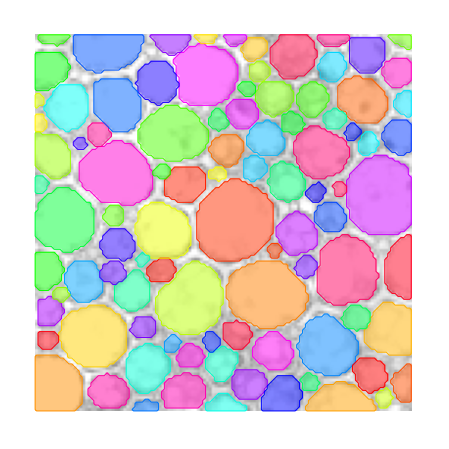

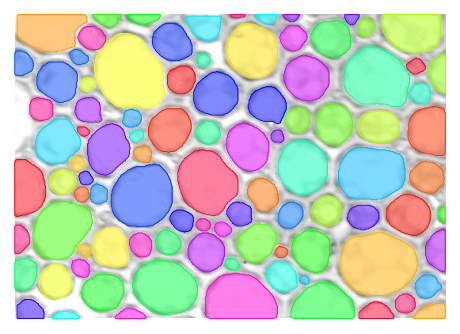

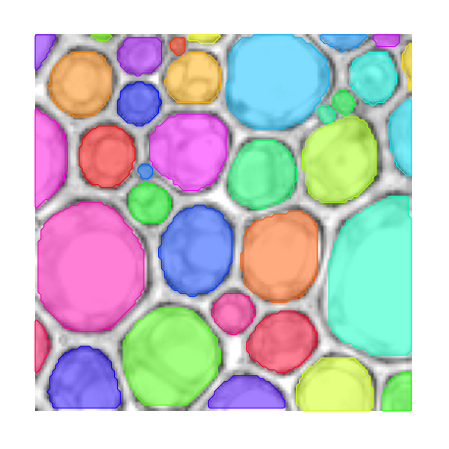

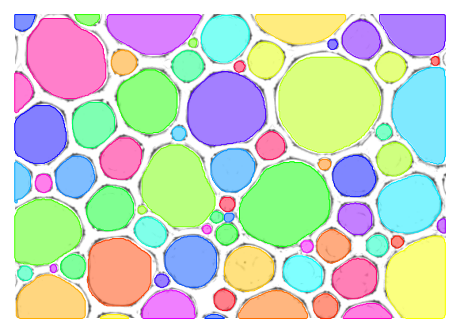

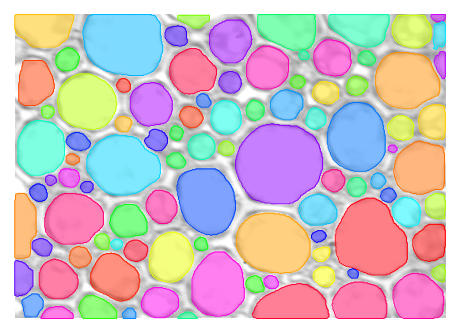

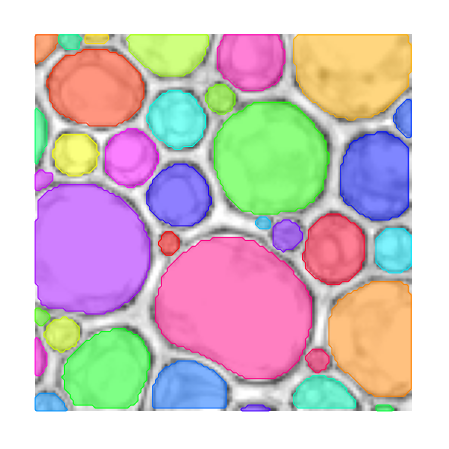

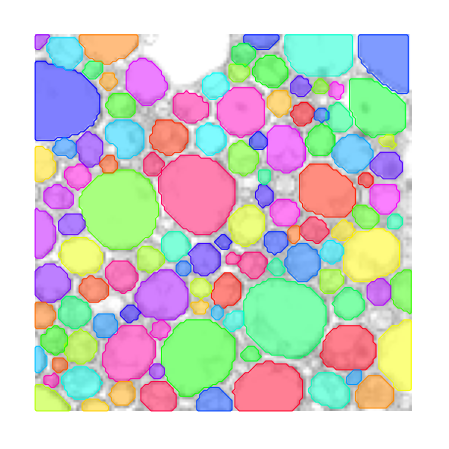

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(x_test_dir))[2]

for image_name in file_names:
  path=os.path.join(x_test_dir, image_name)
  image = cv2.imread(path)
  # Run detection
  results = model.detect([image], verbose=1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', ' '], np.zeros((len(r['class_ids']))) ,ax=get_ax(),show_bbox=False)
  print(len(r['class_ids']))